In [121]:
from datasets import load_dataset

ds = load_dataset("sxdave/emotion_detection")

Resolving data files:   0%|          | 0/157 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

In [122]:
print(ds) # get the info of the dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 157
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 45
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 23
    })
})


In [123]:
print(ds.keys()) # get the label of the dataset

dict_keys(['train', 'validation', 'test'])


In [124]:
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

train_ds, val_ds, test_ds # check the path

(Dataset({
     features: ['image', 'label'],
     num_rows: 157
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 45
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 23
 }))

In [125]:
num_classes = ds["train"].features["label"].num_classes
print(num_classes)

3


### Visualizing and image

Random image path: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1497A1BB0>, 'label': 0}
Image class: 0
Image height: 224
Image width: 224


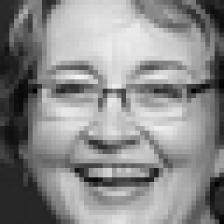

In [126]:
import random

# set seed
random.seed(42)

# pick a random image
random_image = train_ds[random.randrange(len(train_ds))]

# check the class
image_class = random_image['label']

# open image
img = random_image['image']

# print metadata
print(f'Random image path: {random_image}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

(-0.5, 223.5, 223.5, -0.5)

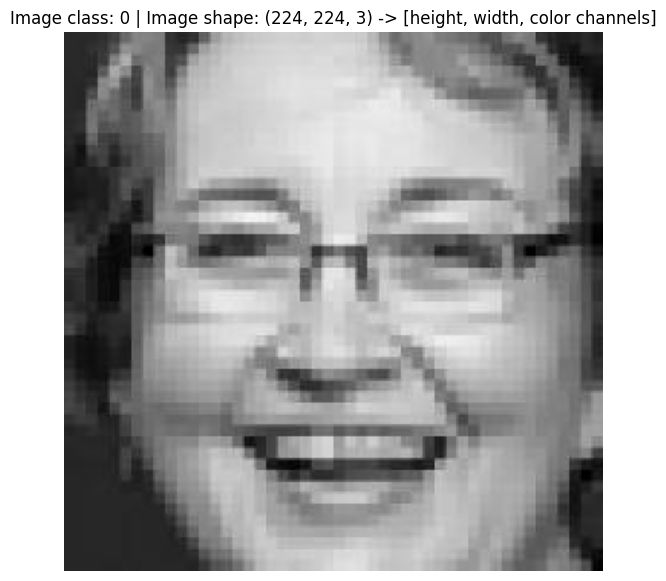

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]')
plt.axis(False)


In [128]:
img_as_array

array([[[40, 40, 40],
        [40, 40, 40],
        [40, 40, 40],
        ...,
        [30, 30, 30],
        [31, 31, 31],
        [32, 32, 32]],

       [[40, 40, 40],
        [40, 40, 40],
        [40, 40, 40],
        ...,
        [30, 30, 30],
        [31, 31, 31],
        [32, 32, 32]],

       [[40, 40, 40],
        [40, 40, 40],
        [41, 41, 41],
        ...,
        [30, 30, 30],
        [31, 31, 31],
        [32, 32, 32]],

       ...,

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [ 9,  9,  9],
        [ 3,  3,  3],
        [ 6,  6,  6]],

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [ 8,  8,  8],
        [ 3,  3,  3],
        [ 6,  6,  6]],

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [ 5,  5,  5],
        [ 0,  0,  0],
        [ 2,  2,  2]]], dtype=uint8)

### Transforming data

In [164]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn

from typing import Tuple, Dict, List

In [130]:
device = 'cpu'

In [131]:
# Write a trandform for image
data_transform = transforms.Compose([
    # Resize our images to 64 * 64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horziontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

data_transform(img).shape

torch.Size([3, 64, 64])

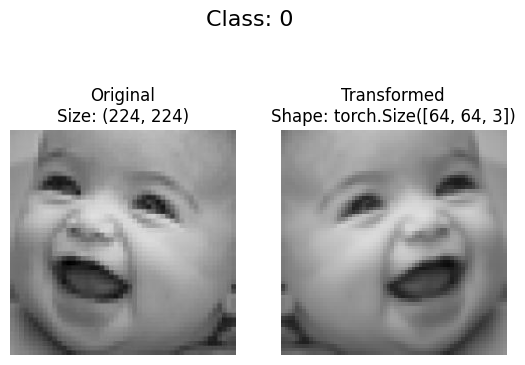

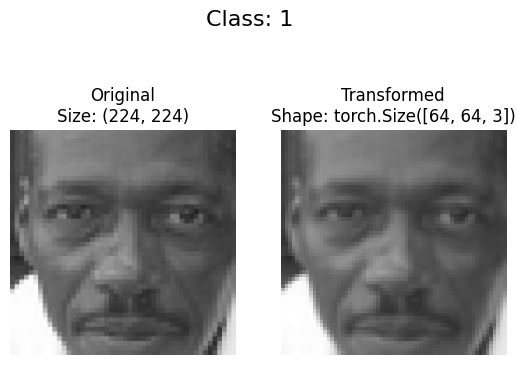

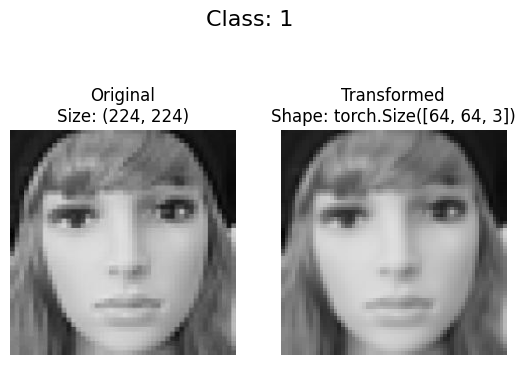

In [132]:
def plot_transformed_images(ds, transform, n=3, seed=None, split=None, image_key='image', label_key='label'):
    """Selects random images from a path of images and loads/transforms 
    them then plots the original vs the transformed version"""

    if seed:
        random.seed(seed)
    
    ds_split = ds[split]
    indices = random.sample(range(len(ds_split)), n)
    
    for idx in indices:
        sample = ds_split[idx]
        img = sample[image_key]
        label = sample[label_key]

        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(img)
        ax[0].set_title(f'Original\nSize: {img.size}')
        ax[0].axis('off')
        
        # Transform and plot target image
        transformed_image = transform(img).permute(1,2,0) # note we will need to change the shape for matplotlib (C, H, W) -> (H, W, C)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
        ax[1].axis('off')

        fig.suptitle(f"Class: {label}", fontsize=16)

plot_transformed_images(ds=ds, 
                        transform=data_transform,
                        n=3,
                        seed=None,
                        split='train')

### Creating new transform

In [148]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### Turn loaded images into `DataLoader`

In [134]:
def collate_fn(batch):
    images = [train_transform(x["image"]) for x in batch]  # PIL -> Tensor
    labels = [x["label"] for x in batch]                  # int
    images = torch.stack(images, dim=0)                   # [Batch, C, H, W]
    labels = torch.tensor(labels)                         # [Batch]
    return images, labels

def test_fn(batch):
    images = [test_transform(x["image"]) for x in batch]
    labels = [x["label"] for x in batch]
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels)
    return images, labels

In [135]:
import os
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset=train_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              collate_fn=collate_fn,
                              shuffle=True)

valid_dataloader = DataLoader(dataset=val_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              collate_fn=test_fn,
                              shuffle=False)

test_dataloader = DataLoader(dataset=test_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              collate_fn=test_fn,
                              shuffle=False)

train_dataloader

In [136]:
# Get image and label from dataloader
img_custom, label_custom = next(iter(train_dataloader))

# Print out rhe shapes
img_custom.shape, label_custom.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

### Create the first model

In [137]:
class TinyVGG(nn.Module):
    """Model architecture copying TinyVGG from CNN Explainer"""
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is the same as kernel size
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is the same as kernel size
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # automatically flat the image without caring for the size, all 1 * 1
            nn.Flatten(),
            nn.Linear(hidden_units, output_shape)
        )
    
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [138]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10, 
                  output_shape=num_classes)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [139]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

In [140]:
# Try the forward pass
model_0(image_batch)

tensor([[-0.0315, -0.0538, -0.1173],
        [-0.0320, -0.0536, -0.1190],
        [-0.0307, -0.0546, -0.1148],
        [-0.0313, -0.0539, -0.1170],
        [-0.0309, -0.0545, -0.1153],
        [-0.0318, -0.0536, -0.1182],
        [-0.0315, -0.0540, -0.1170],
        [-0.0321, -0.0530, -0.1199],
        [-0.0306, -0.0547, -0.1139],
        [-0.0313, -0.0542, -0.1160],
        [-0.0315, -0.0539, -0.1173],
        [-0.0318, -0.0537, -0.1179],
        [-0.0317, -0.0536, -0.1187],
        [-0.0326, -0.0527, -0.1214],
        [-0.0322, -0.0533, -0.1195],
        [-0.0318, -0.0536, -0.1183]], grad_fn=<AddmmBackward0>)

### Create train and test loop functions

In [141]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accurancy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X) # output model logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = y_pred.argmax(dim=1)
        train_acc += ((y_pred_class==y).sum().item()/len(y_pred))

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader) 
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [142]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop thorough DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # 3. Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))
        
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader) 
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### Creating a `train()` function to combine `train_step()` and `test_step()`

In [143]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various models parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
    
    # 2. Create empty results dict
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # 4. Print out what is happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        # 5. Update results dict
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # Return the filled results at the end of epochs
    return results

### Train and evaluate model

In [149]:
# Set random seeds
torch.manual_seed(42)

# Set epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVgg
model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=10,
                  output_shape=num_classes)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=1e-3)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=valid_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

#End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0985 | Train acc: 0.3418 | Test loss: 1.0994 | Test acc: 0.3333
Epoch: 1 | Train loss: 1.0978 | Train acc: 0.3490 | Test loss: 1.0994 | Test acc: 0.3333
Epoch: 2 | Train loss: 1.0978 | Train acc: 0.3404 | Test loss: 1.0994 | Test acc: 0.3333
Epoch: 3 | Train loss: 1.0976 | Train acc: 0.3447 | Test loss: 1.0994 | Test acc: 0.3333
Epoch: 4 | Train loss: 1.0976 | Train acc: 0.3462 | Test loss: 1.0993 | Test acc: 0.3333
Epoch: 5 | Train loss: 1.0978 | Train acc: 0.3447 | Test loss: 1.0994 | Test acc: 0.3333
Epoch: 6 | Train loss: 1.0980 | Train acc: 0.3418 | Test loss: 1.0996 | Test acc: 0.3333
Epoch: 7 | Train loss: 1.0974 | Train acc: 0.3462 | Test loss: 1.0995 | Test acc: 0.3333
Epoch: 8 | Train loss: 1.0973 | Train acc: 0.3447 | Test loss: 1.0993 | Test acc: 0.3333
Epoch: 9 | Train loss: 1.0974 | Train acc: 0.3418 | Test loss: 1.0994 | Test acc: 0.3333
Epoch: 10 | Train loss: 1.0975 | Train acc: 0.3433 | Test loss: 1.0993 | Test acc: 0.3333
Epoch: 11 | Train lo

Since the test result is not so good, I need to do some optimizations..

I merged the original database and then re-partitioned and layered it proportionally

In [151]:
from datasets import concatenate_datasets

all_ds = concatenate_datasets([ds['train'], ds['validation'], ds['test']])

tmp = all_ds.train_test_split(test_size=0.15, stratify_by_column="label", seed=42)
train_val = tmp["train"]
test_ds = tmp["test"]

tmp2 = train_val.train_test_split(test_size=0.15, stratify_by_column="label", seed=42)
train_ds = tmp2['train']
val_ds = tmp2['test']

Updating the transform method, add normalize

In [ ]:
norm = transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # The pixel values ​​are compressed from [0,1] to [−1,1] through mathematical calculations, with the aim of making the model converge faster and perform more stably during training.

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    norm
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    norm
])

And change a little bit of the model...add BatchNorm

In [ ]:
class TinyVGG(nn.Module):
    """Model architecture copying TinyVGG from CNN Explainer"""
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.BatchNorm2d(hidden_units), # The distribution of data is adjusted in real time between neural network layers to prevent data from becoming "distorted" during transmission.
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is the same as kernel size
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is the same as kernel size
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # automatically flat the image without caring for the size, all 1 * 1
            nn.Flatten(),
            nn.Linear(hidden_units, output_shape)
        )
    
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

Let's test again

In [ ]:
# Set random seeds
torch.manual_seed(42)

# Set epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVgg
model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=10,
                  output_shape=num_classes)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=1e-3)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=valid_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

#End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1115 | Train acc: 0.3351 | Test loss: 1.0982 | Test acc: 0.3333
Epoch: 1 | Train loss: 1.0970 | Train acc: 0.3308 | Test loss: 1.0964 | Test acc: 0.2548
Epoch: 2 | Train loss: 1.0926 | Train acc: 0.3760 | Test loss: 1.0940 | Test acc: 0.3734
Epoch: 3 | Train loss: 1.0909 | Train acc: 0.3683 | Test loss: 1.0888 | Test acc: 0.3686
Epoch: 4 | Train loss: 1.0794 | Train acc: 0.3913 | Test loss: 1.0863 | Test acc: 0.4199
Epoch: 5 | Train loss: 1.0804 | Train acc: 0.4091 | Test loss: 1.0849 | Test acc: 0.4615
Epoch: 6 | Train loss: 1.0776 | Train acc: 0.3976 | Test loss: 1.0823 | Test acc: 0.3782
Epoch: 7 | Train loss: 1.0699 | Train acc: 0.4226 | Test loss: 1.0725 | Test acc: 0.4183
Epoch: 8 | Train loss: 1.0725 | Train acc: 0.4226 | Test loss: 1.0720 | Test acc: 0.4391
Epoch: 9 | Train loss: 1.0690 | Train acc: 0.4192 | Test loss: 1.0712 | Test acc: 0.4247
Epoch: 10 | Train loss: 1.0657 | Train acc: 0.4601 | Test loss: 1.0847 | Test acc: 0.2548
Epoch: 11 | Train lo

The result is still not good, try to visualize the process

In [165]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary"""
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

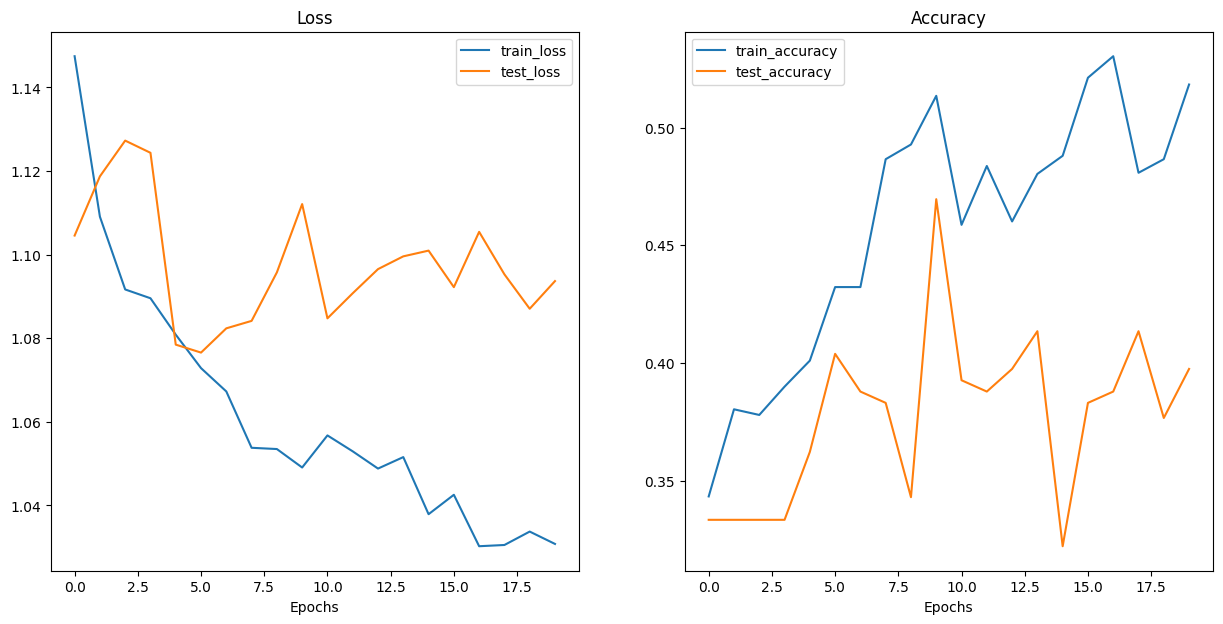

In [166]:
plot_loss_curves(model_0_results)

From the visualization, I found:

1. Overfitting
2. High volatility

Time to find another solution

In [169]:
from torchvision import models
from torchvision.models import ResNet18_Weights

In [ ]:
model_1 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # Load ResNet18 pre-trained model
model_1.fc = nn.Linear(model_1.fc.in_features, num_classes) # Make some changes to full connected layer, out shape = 3
model_1 = model_1.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/yangtianchi/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:06<00:00, 7.68MB/s]


In [ ]:
weights = ResNet18_Weights.DEFAULT # using default weights
mean = weights.transforms().mean # Extract the mean and standard deviation
std = weights.transforms().std

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # 224*224 is the standard inout size of ResNet18
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)        # Normalizing the data caters to the model's "muscle memory."
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [172]:
for p in model_1.parameters():  # turn off all lyaers' learning switch, keep pre-trained model the same
    p.requires_grad = False     
for p in model_1.fc.parameters(): # only turn on the learing switch of full connected layer
    p.requires_grad = True

In [176]:
optimizer = torch.optim.Adam(model_1.fc.parameters(), lr=1e-3, weight_decay=1e-4)

In [180]:
model_1_results = train(model=model_1,
                train_dataloader=train_dataloader,
                test_dataloader=valid_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20,
                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.5345 | Train acc: 0.8486 | Test loss: 1.0825 | Test acc: 0.5481
Epoch: 1 | Train loss: 0.5704 | Train acc: 0.8005 | Test loss: 1.0760 | Test acc: 0.4968
Epoch: 2 | Train loss: 0.5751 | Train acc: 0.7707 | Test loss: 1.0732 | Test acc: 0.5176
Epoch: 3 | Train loss: 0.5842 | Train acc: 0.7726 | Test loss: 1.0921 | Test acc: 0.5321
Epoch: 4 | Train loss: 0.5800 | Train acc: 0.8144 | Test loss: 1.0837 | Test acc: 0.5176
Epoch: 5 | Train loss: 0.5212 | Train acc: 0.8375 | Test loss: 1.0876 | Test acc: 0.5016
Epoch: 6 | Train loss: 0.5460 | Train acc: 0.8361 | Test loss: 1.0837 | Test acc: 0.5433
Epoch: 7 | Train loss: 0.5313 | Train acc: 0.8548 | Test loss: 1.0964 | Test acc: 0.5176
Epoch: 8 | Train loss: 0.5899 | Train acc: 0.7803 | Test loss: 1.0984 | Test acc: 0.5272
Epoch: 9 | Train loss: 0.6275 | Train acc: 0.7048 | Test loss: 1.0962 | Test acc: 0.4920
Epoch: 10 | Train loss: 0.6351 | Train acc: 0.7250 | Test loss: 1.1299 | Test acc: 0.5369
Epoch: 11 | Train lo

so we had a progress, but not too much, maybe change some parameters might help?

In [184]:
for p in model_1.layer4.parameters(): # turn on the layer of high level semantic features, good to extract details
    p.requires_grad = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_1.parameters()), lr=1e-3, weight_decay=1e-4) # The filter function only feeds the Adam optimizer with parameters that require_grad=True

In [188]:
model_1_results = train(model=model_1,
                train_dataloader=train_dataloader,
                test_dataloader=valid_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20,
                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.0045 | Train acc: 1.0000 | Test loss: 2.1453 | Test acc: 0.5801
Epoch: 1 | Train loss: 0.0035 | Train acc: 1.0000 | Test loss: 2.0533 | Test acc: 0.6010
Epoch: 2 | Train loss: 0.0074 | Train acc: 1.0000 | Test loss: 2.0633 | Test acc: 0.5593
Epoch: 3 | Train loss: 0.0125 | Train acc: 1.0000 | Test loss: 2.1184 | Test acc: 0.5593
Epoch: 4 | Train loss: 0.0948 | Train acc: 0.9644 | Test loss: 2.1917 | Test acc: 0.5801
Epoch: 5 | Train loss: 0.0082 | Train acc: 1.0000 | Test loss: 2.1304 | Test acc: 0.5593
Epoch: 6 | Train loss: 0.0111 | Train acc: 0.9923 | Test loss: 2.1623 | Test acc: 0.5593
Epoch: 7 | Train loss: 0.0320 | Train acc: 0.9750 | Test loss: 2.1894 | Test acc: 0.6010
Epoch: 8 | Train loss: 0.0102 | Train acc: 0.9938 | Test loss: 2.1350 | Test acc: 0.5593
Epoch: 9 | Train loss: 0.0073 | Train acc: 1.0000 | Test loss: 2.0940 | Test acc: 0.5593
Epoch: 10 | Train loss: 0.0367 | Train acc: 0.9812 | Test loss: 2.1644 | Test acc: 0.6010
Epoch: 11 | Train lo

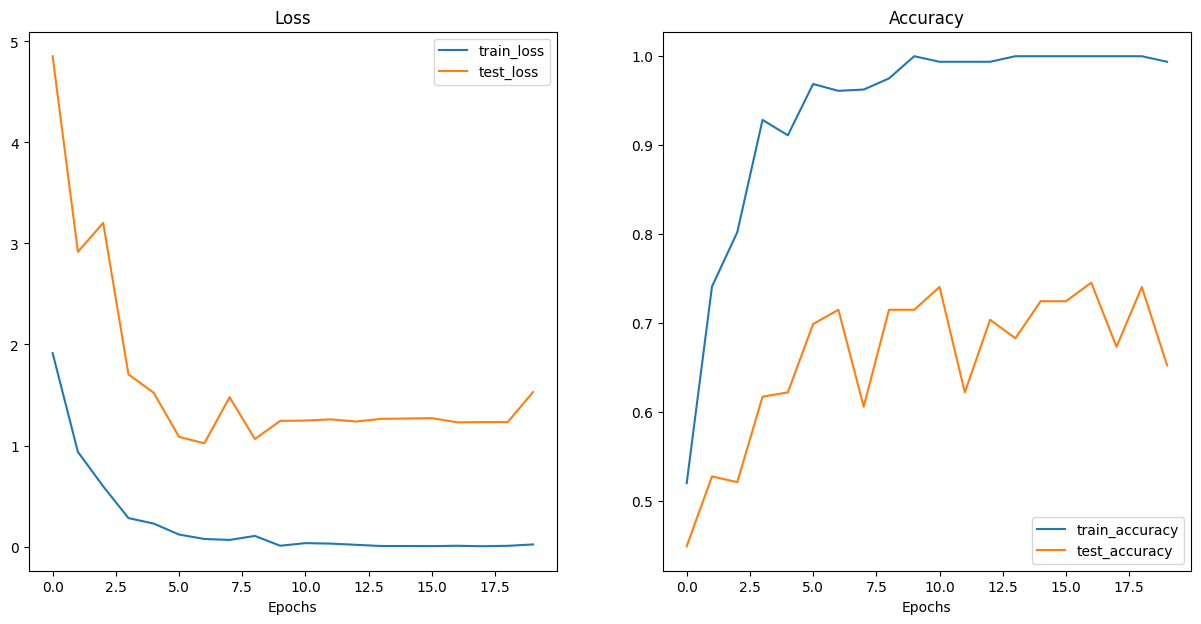

In [183]:
plot_loss_curves(model_1_results)